In [ ]:
# Note the structure of the data in our colab file directory. As directed in the CompCars Dataset we will be using 
# the clasification train_test_split data inside the 'data' directory
ls

combined_sv.zip  data.z04*  data.z10*  data.z16*  data.z22*     sv_data.z01*
combined.zip     data.z05*  data.z11*  data.z17*  data.zip*     sv_data.z02*
data/            data.z06*  data.z12*  data.z18*  full.zip      sv_data.z03*
data.z01*        data.z07*  data.z13*  data.z19*  README.txt*   sv_data.zip*
data.z02*        data.z08*  data.z14*  data.z20*  sample_data/
data.z03*        data.z09*  data.z15*  data.z21*  sv_data/


In [82]:
#make initial imports

import cv2
import pandas as pd
from keras_preprocessing.image import ImageDataGenerator
from keras.layers import Dense, Activation, Flatten, Dropout, BatchNormalization, GlobalAveragePooling2D
from keras.layers import Conv2D, MaxPooling2D
from keras import regularizers, optimizers
from keras.models import Sequential
from keras.applications.inception_v3 import InceptionV3

In [ ]:
# cd to where data has been saved
cd /content/data/

/content/data


In [142]:
# get overall train test df from respective directories

train_df = pd.read_csv('/content/data/train_test_split/classification/train.txt', sep='/', names = ['make', 'model', 'year','image'])
test_df = pd.read_csv('/content/data/train_test_split/classification/test.txt', sep='/', names = ['make', 'model', 'year','image'])
train_df["model"]=train_df["model"].apply(str)
test_df["model"]=test_df["model"].apply(str)
class_names = sorted(list(test_df['model'].unique()))

In [ ]:
#use Image Data Generator for Data Loading

train_datagen=ImageDataGenerator(rescale=1./255., shear_range=0.2, zoom_range=0.2,
                                  rotation_range=45,horizontal_flip=True,vertical_flip=True)
test_datagen = ImageDataGenerator(rescale=1./255)

train_generator=train_datagen.flow_from_dataframe(
dataframe=train_df,
directory="./alllabels",
x_col="image",
y_col="model",
batch_size=32,
seed=42,
shuffle=True,
class_mode="categorical",
target_size=(512,512))

valid_generator=test_datagen.flow_from_dataframe(
dataframe=test_df,
directory="./alllabels",
x_col="image",
y_col="model",
batch_size=32,
seed=42,
shuffle=False,
class_mode="categorical",
target_size=(512,512))

type(train_generator)

Found 16016 validated image filenames belonging to 431 classes.
Found 14939 validated image filenames belonging to 431 classes.


keras_preprocessing.image.dataframe_iterator.DataFrameIterator

In [ ]:
# Inception v3 model architecture with adjusted final layer and freezing everything except last 100 layers. This will help reduce training time.

base_model = InceptionV3(weights='imagenet', 
                                include_top=False,
                                input_shape=(512,512,3))

for layer in base_model.layers[:-100]:
  layer.trainable = False
for layer in base_model.layers[-100:]:
  layer.trainable = True

add_model = Sequential()
add_model.add(base_model)
add_model.add(GlobalAveragePooling2D())
add_model.add(Dropout(0.5))
add_model.add(Dense(431, activation='softmax'))
add_model.compile('Adam',loss="categorical_crossentropy",metrics=["accuracy"])

In [ ]:
# training and testing as per the given split

add_model.fit_generator(generator=train_generator,
                    validation_data= valid_generator,
                    validation_steps= int(len(test_df)//32),
                    steps_per_epoch=int(len(train_df)//32),
                    epochs=20
)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  """


Epoch 1/20
500/500 [==============================] - 2497s 5s/step - loss: 5.7996 - accuracy: 0.0170 - val_loss: 5.4213 - val_accuracy: 0.0406
Epoch 2/20
500/500 [==============================] - 2491s 5s/step - loss: 4.6898 - accuracy: 0.0851 - val_loss: 3.8958 - val_accuracy: 0.1624
Epoch 3/20
500/500 [==============================] - 2465s 5s/step - loss: 3.4852 - accuracy: 0.2168 - val_loss: 2.6994 - val_accuracy: 0.3634
Epoch 4/20
500/500 [==============================] - 2477s 5s/step - loss: 2.5447 - accuracy: 0.3755 - val_loss: 2.1507 - val_accuracy: 0.4502
Epoch 5/20
500/500 [==============================] - 2407s 5s/step - loss: 1.8901 - accuracy: 0.5103 - val_loss: 1.4562 - val_accuracy: 0.6193
Epoch 6/20
500/500 [==============================] - 2409s 5s/step - loss: 1.4442 - accuracy: 0.6122 - val_loss: 1.2728 - val_accuracy: 0.6579
Epoch 7/20
500/500 [==============================] - 2425s 5s/step - loss: 1.1386 - accuracy: 0.6816 - val_loss: 1.0762 - val_accuracy:

In [ ]:
add_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 inception_v3 (Functional)   (None, 14, 14, 2048)      21802784  
                                                                 
 global_average_pooling2d (G  (None, 2048)             0         
 lobalAveragePooling2D)                                          
                                                                 
 dropout (Dropout)           (None, 2048)              0         
                                                                 
 dense (Dense)               (None, 431)               883119    
                                                                 
Total params: 22,685,903
Trainable params: 14,507,183
Non-trainable params: 8,178,720
_________________________________________________________________


In [ ]:
# Calling `save('my_model')` creates a SavedModel folder `my_model`.

add_model.save("my_model")

INFO:tensorflow:Assets written to: my_model/assets


In [5]:
# load the above model back 

from tensorflow import keras
add_model = keras.models.load_model('my_model')

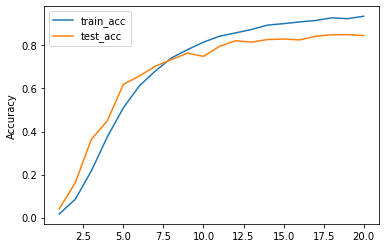

In [179]:
#Accuracy Plots by feeding accuracy values shown above

import matplotlib.pyplot as plt
train_acc = [0.0170,0.0851,0.2168,0.3755,0.5103,0.6122,0.6816,0.7417,0.7803,0.8153,0.8428,0.8582,0.8742,0.8945,0.9013,
             0.9093,0.9160,0.9282,0.9244,0.9357]
x = [1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20]
test_acc = [0.0406,0.1624,0.3634,0.4502,0.6193,0.6579,0.7035,0.7340,0.7641,0.7492,0.7958,0.8217,0.8152,0.8275,0.8298,
            0.8258,0.8426,0.8496,0.8503,0.8459]
plt.plot(x, train_acc, label = "train_acc")
plt.plot(x, test_acc, label = "test_acc")
plt.ylabel('Accuracy')
plt.legend()
plt.show()

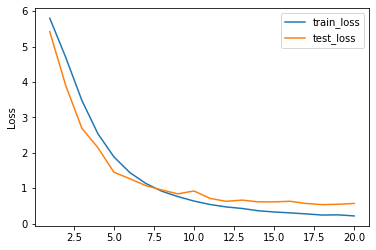

In [180]:
#Loss Plots by feeding loss values shown above

train_loss = [5.7996,4.6898,3.4852,2.5447,1.8901,1.4442,1.1386,0.9189,0.7686,0.6428,0.5452,0.4777,0.4335,0.3694,0.3351,0.3092,0.2806,0.2484,0.2537,0.2234]
x = [1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20]
test_loss = [5.4213,3.8958,2.6994,2.1507,1.4562,1.2728,1.0762,0.9546,0.8461,0.9275,0.7186,0.6354,0.6692,0.6205,0.6194,0.6363,0.5735,0.5413,0.5510,0.5761]
plt.plot(x, train_loss, label = "train_loss")
plt.plot(x, test_loss, label = "test_loss")
plt.ylabel('Loss')
plt.legend()
plt.show()

In [183]:
# Now, let us visualize these test results

import cv2
import numpy as np

img1 = cv2.imread('/content/data/image/78/22/2012/0f872d5c958476.jpg')
img1 = cv2.resize(img1,(512,512))
img1 = cv2.cvtColor(img1, cv2.COLOR_BGR2RGB)/255.0

img2 = cv2.imread('/content/data/image/78/27/2009/078356ae6206f8.jpg')
img2 = cv2.resize(img2,(512,512))
img2 = cv2.cvtColor(img2, cv2.COLOR_BGR2RGB)/255.0

img3 = cv2.imread('/content/data/image/28/1885/2010/ce34d4e18271a1.jpg')
img3 = cv2.resize(img3,(512,512))
img3 = cv2.cvtColor(img3, cv2.COLOR_BGR2RGB)/255.0

img4 = cv2.imread('/content/data/image/157/1946/2011/9cf2b9ae3bf1f2.jpg')
img4 = cv2.resize(img4,(512,512))
img4 = cv2.cvtColor(img4, cv2.COLOR_BGR2RGB)/255.0

labels = ['22','27','1885','1946']

image_array = np.array([img1, img2, img3, img4])
preds = add_model.predict(image_array)
preds = np.argmax(preds, axis=-1)

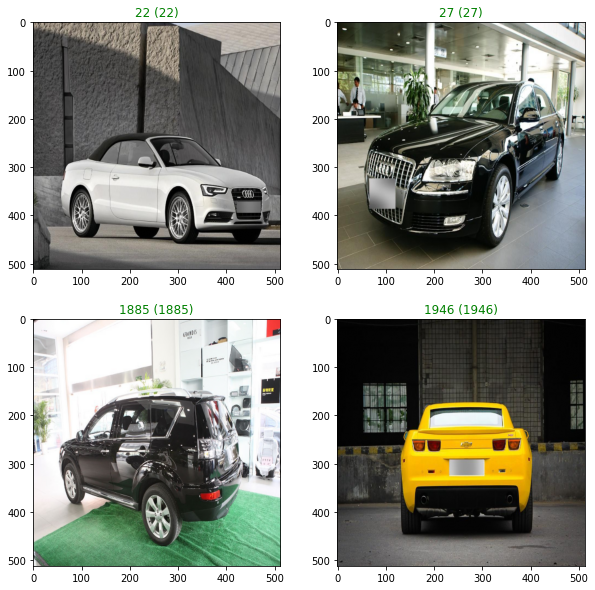

In [185]:
# Plot the images in the batch, along with predicted and true labels

fig = plt.figure(figsize=(10, 10))
for idx in np.arange(len(preds)):
  ax = fig.add_subplot(2, len(preds)//2, idx+1)
  image = image_array[idx]
  ax.imshow(image)
  ax.set_title("{} ({})".format(class_names[preds[idx]], labels[idx]),
              color=("green" if class_names[preds[idx]]==labels[idx] else "red"))